# **Convolutional Neural Network (CNN)**

### **1. Imports**

In [15]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.auto import tqdm

# checking verions
import sys
print(sys.version) # python
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.2.1+cu121
0.17.1+cu121


### **2. Manual Seed**


In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### **3. DataSets(`FashionMNIST`)**

In [16]:
# FashionMNIST
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

### **4. Checking `Shape`/`Size`**





In [17]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [44]:
# Access the first element of train_data
train_data[0]

# Unpack the first element of train_data into `image` and `label` variables
image, label = train_data[0]

# Print the shape of the image tensor
print(image.shape)

# NOTE: It does not remove the color channel
# Removes any single-dimensional entries from the shape of the image tensor
print(image.squeeze().shape)

# Adding a new dimension at dim=0 (batch dimension)
print(image.unsqueeze(dim=0).shape)

# Print the label associated with the image
print(label)

torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 28, 28])
9


In [27]:
class_names = train_data.classes
print(class_names)

class_to_idx = train_data.class_to_idx
print(class_to_idx)

print(train_data.targets)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
tensor([9, 0, 0,  ..., 3, 0, 5])


### **Visualizing the data Sample**

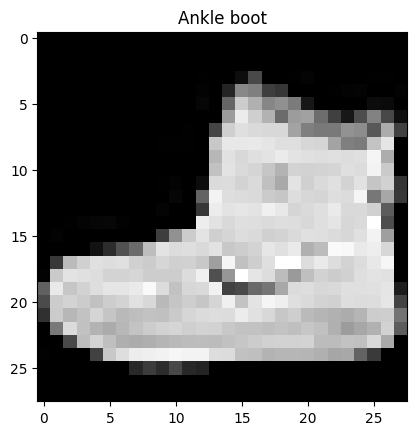

In [56]:
# Ploting the single sample
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.show()

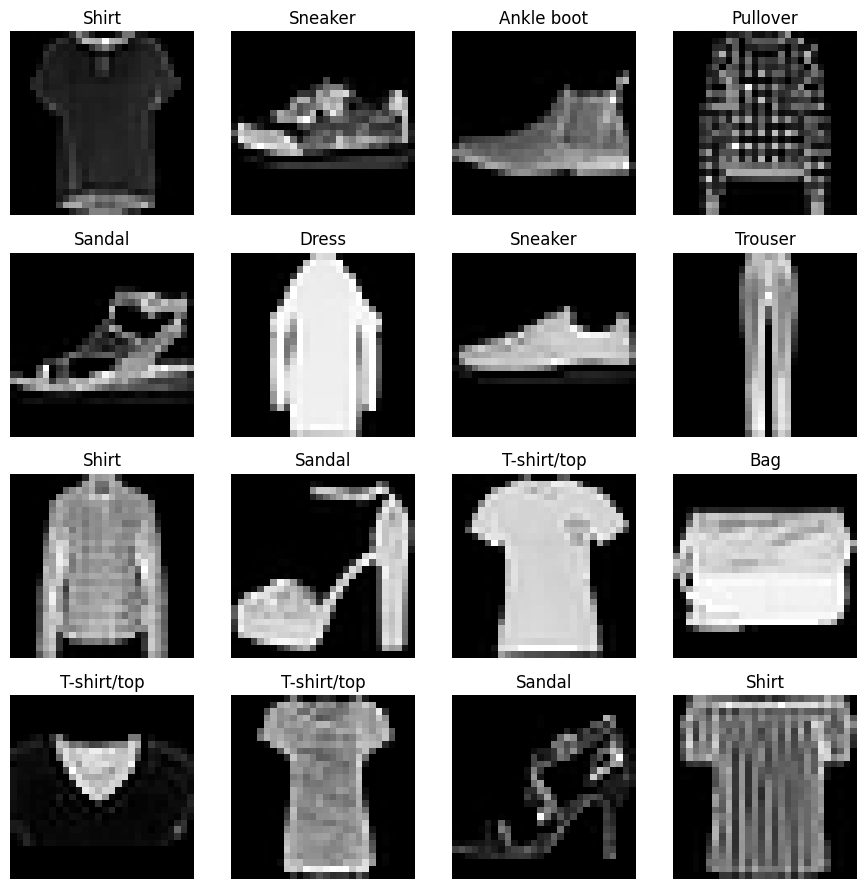

In [71]:
# Plotting the grid of samples
fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4
# Loop for generating and plotting 16 random samples
for i in range(1, (rows*cols+1)):  # Range adjusted to generate 16 samples (4x4 grid)
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    ax = fig.add_subplot(rows, cols, i)  # Subplot index starts from 1
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(class_names[label])
    ax.axis('off')  # Turning off axis labels
plt.tight_layout()  # Adjusting layout for better display
plt.show()

### **DataLoader**